# EDA: CrisisMMD v2.0

This notebook performs a thorough EDA for the CrisisMMD multimodal dataset (text + image). It focuses on:
- label distributions (text / image / combined)
- text length (chars & tokenizer tokens)
- basic text features (hashtags, mentions, URLs, punctuation)
- image availability, readability and quality
- multi-image handling per tweet
- agreement between text labels and image labels (confusion matrix, Cohen's kappa)
- quick qualitative sampling


In [1]:
import os
import json
import re
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image, UnidentifiedImageError
from sklearn.metrics import confusion_matrix, cohen_kappa_score
from transformers import AutoTokenizer
import cv2


TSV_PATH = "../data/crisismmd_datasplit_all/task_humanitarian_text_img_train.tsv"
IMG_ROOT = "../data"
SAMPLE_SEED = 42

random.seed(SAMPLE_SEED)
np.random.seed(SAMPLE_SEED)


/home/lenovo/crisis-eye/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# load data
df = pd.read_csv(TSV_PATH, sep="\t", low_memory=False)
df.columns = [c.strip() for c in df.columns]   # normalize
print("Shape:", df.shape)
print("Columns:", list(df.columns))
df.head(3)


Shape: (13608, 9)
Columns: ['event_name', 'tweet_id', 'image_id', 'tweet_text', 'image', 'label', 'label_text', 'label_image', 'label_text_image']


,event_name,tweet_id,image_id,tweet_text,image,label,label_text,label_image,label_text_image
0,california_wildfires,917791291823591425,917791291823591425_1,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,not_humanitarian,other_relevant_information,not_humanitarian,Negative
1,california_wildfires,917791291823591425,917791291823591425_0,RT @Cal_OES: PLS SHARE: Weâ€™re capturing wild...,data_image/california_wildfires/10_10_2017/917...,other_relevant_information,other_relevant_information,infrastructure_and_utility_damage,Negative
2,california_wildfires,917793137925459968,917793137925459968_0,RT @KAKEnews: California wildfires destroy mor...,data_image/california_wildfires/10_10_2017/917...,infrastructure_and_utility_damage,infrastructure_and_utility_damage,infrastructure_and_utility_damage,Positive


In [3]:
# missing values & basic label counts
print("Missing values per column:")
print(df.isna().sum())

print("\nUnique value counts for label columns:")
for c in ["label", "label_text", "label_image", "label_text_image"]:
    print(c, "unique:", df[c].nunique())
    
print("\nValue counts (top) for label, label_image, label_text_image:")
print("\nlabel (text) distribution:")
print(df["label"].value_counts().head(20))
print("\nlabel_image (image) distribution:")
print(df["label_image"].value_counts().head(20))
print("\nlabel_text_image (combined) distribution:")
print(df["label_text_image"].value_counts())


Missing values per column:
event_name          0
tweet_id            0
image_id            0
tweet_text          0
image               0
label               0
label_text          0
label_image         0
label_text_image    0
dtype: int64

Unique value counts for label columns:
label unique: 8
label_text unique: 8
label_image unique: 8
label_text_image unique: 2

Value counts (top) for label, label_image, label_text_image:

label (text) distribution:
label
not_humanitarian                          5260
other_relevant_information                3294
rescue_volunteering_or_donation_effort    2323
infrastructure_and_utility_damage         1905
affected_individuals                       424
injured_or_dead_people                     244
vehicle_damage                             134
missing_or_found_people                     24
Name: count, dtype: int64

label_image (image) distribution:
label_image
not_humanitarian                          6565
infrastructure_and_utility_damage         27

## Quick data snapshot

- **Rows:** 13,608  
- **Unique image filenames:** 13,608  
- **Rows with missing image file:** 0 (all paths present)  
- **Unreadable/corrupt images:** 0  
- **Unique `label_text` classes:** 8  
- **Unique `label_image` classes:** 8  
- **`label_text_image` (combined Informative/Not):** 2 classes (Negative: 7,482; Positive: 6,126)


In [4]:
# text length (chars) and token lengths (DistilBERT)
df["tweet_text"] = df["tweet_text"].astype(str)
df["text_char_len"] = df["tweet_text"].apply(len)
print("Text (char) length stats:")
print(df["text_char_len"].describe())

char_percentiles = {p: float(np.percentile(df["text_char_len"], p)) for p in [50,75,90,95,99]}
print("Char percentiles:", char_percentiles)


tokenizer = AutoTokenizer.from_pretrained("distilbert-base-uncased")

def tok_len(text):
    return len(tokenizer.encode(text, add_special_tokens=True))
df["text_token_len"] = df["tweet_text"].apply(tok_len)
print("\nToken length stats (DistilBERT):")
print(df["text_token_len"].describe())
token_percentiles = {p: int(np.percentile(df["text_token_len"], p)) for p in [50,75,90,95,99]}
print("Token percentiles:", token_percentiles)


Text (char) length stats:
count    13608.000000
mean       117.479424
std         20.030839
min         38.000000
25%        106.000000
50%        122.000000
75%        134.000000
max        182.000000
Name: text_char_len, dtype: float64
Char percentiles: {50: 122.0, 75: 134.0, 90: 139.0, 95: 140.0, 99: 145.0}

Token length stats (DistilBERT):
count    13608.000000
mean        45.191725
std          7.925810
min         20.000000
25%         41.000000
50%         46.000000
75%         50.000000
max        101.000000
Name: text_token_len, dtype: float64
Token percentiles: {50: 46, 75: 50, 90: 55, 95: 57, 99: 64}


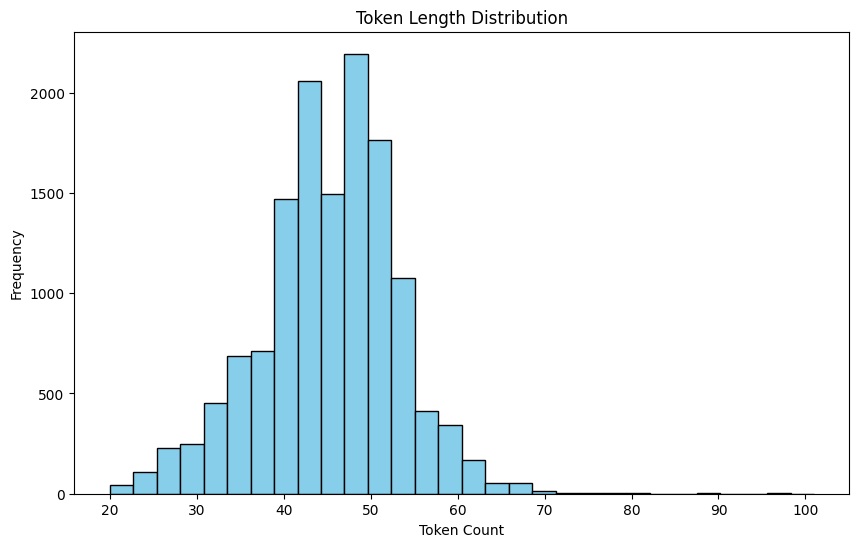

In [5]:
plt.figure(figsize=(10,6))
plt.hist(df["text_token_len"], bins=30, color="skyblue", edgecolor="black")
plt.title("Token Length Distribution")
plt.xlabel("Token Count")
plt.ylabel("Frequency")
plt.show()


## Text length interpretation

- **Character lengths**: median = **122 chars**, 75th = **134 chars**, 95th = **140 chars**, max = 182 chars.  
  -> Tweets are short but not tiny single-word messages.

- **Token lengths** (DistilBERT): median = **46 tokens**, 75th = **50**, 95th = **57**, max = **101**.  
  -> Using `max_length = 128` (tokens) would safely cover >99% of examples; `max_length = 64` would cover ~99%+ depending on margin. In the run, **95th token percentile = 57**.


In [6]:
# simple text features (hashtags, mentions, urls, punctuation, uppercase ratio)
url_re = re.compile(r"https?://\S+|www\.\S+")
hashtag_re = re.compile(r"#\w+")
mention_re = re.compile(r"@\w+")

def text_features(s):
    s = str(s)
    urls = bool(url_re.search(s))
    hashtags = hashtag_re.findall(s)
    mentions = mention_re.findall(s)
    words = s.split()
    word_count = len(words)
    exclam = s.count("!")
    qmarks = s.count("?")
    upper_chars = sum(1 for ch in s if ch.isupper())
    upper_ratio = upper_chars / max(1, len(s))
    digits = sum(1 for ch in s if ch.isdigit())
    return {
        "word_count": word_count,
        "has_urls": int(urls),
        "num_hashtags": len(hashtags),
        "num_mentions": len(mentions),
        "exclamations": exclam,
        "questions": qmarks,
        "upper_ratio": upper_ratio,
        "digits": digits
    }

tf = df["tweet_text"].apply(text_features).apply(pd.Series)
df = pd.concat([df, tf], axis=1)

print("Sample text features (top 5):")
print(df[["tweet_text","word_count","num_hashtags","num_mentions","has_urls","exclamations","upper_ratio"]].head().to_string())
print("\nText feature summary:")
print(df[["word_count","num_hashtags","num_mentions","has_urls","exclamations","upper_ratio","digits"]].describe().to_string())


Sample text features (top 5):
                                                                                                                         tweet_text  word_count  num_hashtags  num_mentions  has_urls  exclamations  upper_ratio
0  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wildfire response, recovery info here: https://t.co/r89LKpjLPj https://t.co/HiA1oQF2Ax        13.0           0.0           1.0       1.0           0.0       0.1875
1  RT @Cal_OES: PLS SHARE: Weâ€™re capturing wildfire response, recovery info here: https://t.co/r89LKpjLPj https://t.co/HiA1oQF2Ax        13.0           0.0           1.0       1.0           0.0       0.1875
2     RT @KAKEnews: California wildfires destroy more than 50 structures: https://t.co/IkSrNpmT83 #KAKEnews https://t.co/8risKwbBqr        12.0           1.0           1.0       1.0           0.0       0.1360
3     RT @KAKEnews: California wildfires destroy more than 50 structures: https://t.co/IkSrNpmT83 #KAKEnews https://t.co/8risKwbBqr   

## Text features notes:

- Average word count ≈ **13.85** (median 14).  
- Many tweets contain URLs (the dataset includes tweets/RTs that reference news or images).  
- Uppercase ratio is small on average (~0.12) but some tweets have aggressive uppercase (panic shouting) which can be a signal.  
- Keep these features available for simple baselines and error analysis (e.g., text-only model errors often coincide with short, URL-only, or RT texts).

In [7]:
# image splitting, existence, readability, basic stats
def split_image_field(val):
    if pd.isna(val):
        return []
    if isinstance(val, str) and ((";" in val) or ("|" in val) or ("," in val)):
        for sep in [";", "|", ","]:
            if sep in val:
                return [p.strip() for p in val.split(sep) if p.strip()]
    return [str(val).strip()] if str(val).strip() else []

df["image_list"] = df["image"].apply(split_image_field)
df["n_images"] = df["image_list"].apply(len)

print("Image counts per row (value counts):")
print(df["n_images"].value_counts().to_string())

# gather unique images and check filesystem existence
all_images = sorted({img for lst in df["image_list"] for img in lst})
print("Unique image filenames:", len(all_images))

def img_exists(fname):
    return os.path.exists(os.path.join(IMG_ROOT, fname))

df["image_path_exists_any"] = df["image_list"].apply(lambda lst: any(img_exists(i) for i in lst))
print("Image path existence across rows:")
print(df["image_path_exists_any"].value_counts())

# Image readability & stats
bad_images = []
img_stats = []
for fname in all_images:
    path = os.path.join(IMG_ROOT, fname)
    if not os.path.exists(path):
        bad_images.append((fname,"not_found"))
        continue
    try:
        im = Image.open(path).convert("RGB")
        w,h = im.size
        arr = np.array(im)
        mean_pixel = float(arr.mean())
        std_pixel = float(arr.std())
        aspect = float(w)/float(h) if h>0 else None
        blur_var = None
        gray = cv2.cvtColor(arr, cv2.COLOR_RGB2GRAY)
        blur_var = float(cv2.Laplacian(gray, cv2.CV_64F).var())
        img_stats.append({"fname":fname,"width":w,"height":h,"aspect":aspect,"mean_pixel":mean_pixel,"std_pixel":std_pixel,"blur_var":blur_var})
    except UnidentifiedImageError:
        bad_images.append((fname,"unreadable"))
    except Exception as e:
        bad_images.append((fname,str(e)))

img_stats_df = pd.DataFrame(img_stats)
print("Total unreadable / missing images:", len(bad_images))
if not img_stats_df.empty:
    print("Image stats summary:")
    print(img_stats_df[["width","height","aspect","mean_pixel","std_pixel","blur_var"]].describe().to_string())


Image counts per row (value counts):
n_images
1    13608
Unique image filenames: 13608
Image path existence across rows:
image_path_exists_any
True    13608
Name: count, dtype: int64


/home/lenovo/crisis-eye/.venv/lib/python3.12/site-packages/PIL/Image.py:1039: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


Total unreadable / missing images: 0
Image stats summary:
              width        height        aspect    mean_pixel     std_pixel      blur_var
count  13608.000000  13608.000000  13608.000000  13608.000000  13608.000000  13608.000000
mean     871.766755    666.785641      1.441423    120.912875     64.004059   2447.829316
std      285.832726    284.219255      0.531591     45.415685     14.684691   3646.383368
min       18.000000     16.000000      0.250977      0.000000      0.000000      0.000000
25%      640.000000    450.000000      1.185902     91.900395     55.052710    524.389592
50%      900.000000    650.000000      1.499250    114.231787     64.481392   1310.078896
75%     1200.000000    874.000000      1.777778    141.205566     73.008264   3047.955177
max     1200.000000   1200.000000     11.257143    255.000000    124.215335  74200.063434


## Image stats summary

- **Unique images:** 13,608  
- **Rows with no image file:** 0 (all image paths present)  
- **Unreadable images:** 0  
- **Image resolution distribution** (from your run): median width ≈ **900 px**, median height ≈ **650 px**, 25% width ~640, 75% width ~1200.  
- **Aspect ratio** median ≈ **1.5** (landscape-dominant).  
- **Blur / brightness**: statistics were computed. There are some very low mean/flat images (min mean_pixel = 0), and a long tail in blur variance.


In [8]:
# multi-image per tweet and duplicate check
if "tweet_id" in df.columns:
    img_counts_by_tweet = df.groupby("tweet_id")["n_images"].sum()
    print("Images per tweet (summary):")
    print(img_counts_by_tweet.describe().to_string())
    print("Tweets with >1 image:", (img_counts_by_tweet > 1).sum())
else:
    print("No tweet_id column; skipping tweet-level multi-image aggregation.")

# Safe duplicate check (convert list-like columns to tuples)
df_dup = df.copy()
for col in df_dup.columns:
    try:
        if df_dup[col].apply(lambda v: isinstance(v, (list, tuple))).any():
            df_dup[col] = df_dup[col].apply(lambda v: tuple(v) if isinstance(v, (list, tuple)) else v)
    except Exception:
        df_dup[col] = df_dup[col].apply(lambda v: json.dumps(v, default=str) if not pd.isna(v) else v)

print("Exact duplicated rows (safe):", df_dup.duplicated().sum())
if "tweet_id" in df.columns:
    print("Unique tweet_id count:", df["tweet_id"].nunique(), "vs rows:", df.shape[0])


Images per tweet (summary):
count    11584.000000
mean         1.174724
std          0.590316
min          1.000000
25%          1.000000
50%          1.000000
75%          1.000000
max          4.000000
Tweets with >1 image: 1145
Exact duplicated rows (safe): 0
Unique tweet_id count: 11584 vs rows: 13608


## Multi-image note

- Showed **11584 unique tweets** vs **13608 rows**, meaning some tweets have multiple rows (multi-image tweets).  
- There are **1,145 tweets** with >1 image.  
- Policy decision needed for modeling:
  - Baseline: keep first image per tweet.
  - Better: aggregate image embeddings (mean/max pooling) or use an attention module to weigh multiple images.
- For EDA/first models the "first-image" policy is an acceptable simple baseline; the multi-image cases are numerous enough (~10% of tweets) that exploring aggregation later is worthwhile.


In [9]:
# agreement between label_text and label_image
common_idx = df[(df["label_text"].notna()) & (df["label_image"].notna())]
print("Rows with both label_text and label_image present:", common_idx.shape[0])

labels_text = common_idx["label_text"].astype(str)
labels_image = common_idx["label_image"].astype(str)
agree_pct = (labels_text == labels_image).mean()
kappa = cohen_kappa_score(labels_text, labels_image)
print("Agreement %:", round(agree_pct*100,3))
print("Cohen's kappa:", round(kappa,4))

# confusion matrix
labset = sorted(list(set(labels_text.unique()) | set(labels_image.unique())))
cm = confusion_matrix(labels_text, labels_image, labels=labset)
cm_df = pd.DataFrame(cm, index=labset, columns=labset)
print("\nConfusion matrix (rows=text, cols=image):")
print(cm_df.to_string())

# examine label_text_image (binary) counts
print("\nlabel_text_image distribution:")
print(df["label_text_image"].value_counts())


Rows with both label_text and label_image present: 13608
Agreement %: 45.018
Cohen's kappa: 0.2833

Confusion matrix (rows=text, cols=image):
                                        affected_individuals  infrastructure_and_utility_damage  injured_or_dead_people  missing_or_found_people  not_humanitarian  other_relevant_information  rescue_volunteering_or_donation_effort  vehicle_damage
affected_individuals                                      47                                117                       4                        0               126                          26                                      52              12
infrastructure_and_utility_damage                         32                                595                       4                        0               254                         105                                      77              35
injured_or_dead_people                                    18                                148                      

In [10]:
# class balance
def class_balance(col):
    s = df[col].fillna("<<NA>>").astype(str)
    counts = s.value_counts()
    pct = counts / counts.sum() * 100
    return pd.concat([counts, pct], axis=1, keys=["count","percent"])

print("Class balance: label_text")
print(class_balance("label_text").to_string())
print("\nClass balance: label_image")
print(class_balance("label_image").to_string())
print("\nClass balance: label_text_image")
print(class_balance("label_text_image").to_string())

Class balance: label_text
                                        count    percent
label_text                                              
other_relevant_information               4817  35.398295
not_humanitarian                         3970  29.174015
rescue_volunteering_or_donation_effort   2867  21.068489
infrastructure_and_utility_damage        1102   8.098178
injured_or_dead_people                    393   2.888007
affected_individuals                      384   2.821869
vehicle_damage                             46   0.338036
missing_or_found_people                    29   0.213110

Class balance: label_image
                                        count    percent
label_image                                             
not_humanitarian                         6565  48.243680
infrastructure_and_utility_damage        2761  20.289536
other_relevant_information               1860  13.668430
rescue_volunteering_or_donation_effort   1694  12.448560
affected_individuals              

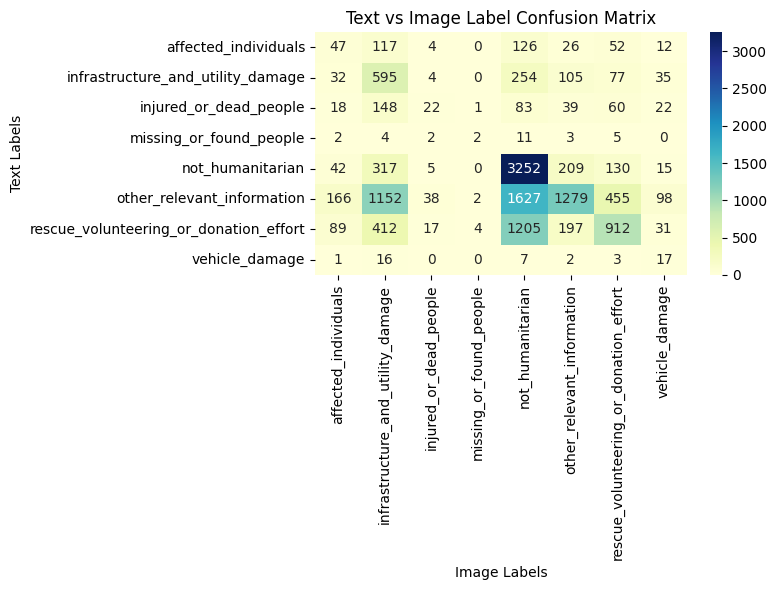

In [11]:
plt.figure(figsize=(8,6))
sns.heatmap(cm_df, annot=True, fmt='d', cmap='YlGnBu')
plt.title("Text vs Image Label Confusion Matrix")
plt.ylabel("Text Labels")
plt.xlabel("Image Labels")
plt.tight_layout()
plt.show()

## Agreement (text vs image)

- **Agreement %:** **45.018%**  
- **Cohen's kappa:** **0.2833** (low–moderate agreement)  
- The confusion matrix shows specific label-pairs where disagreements concentrate. For example, many `other_relevant_information` text labels are assigned to `infrastructure_and_utility_damage` by image labels and vice versa, indicating annotation differences and/or that images and text emphasize different aspects of the same post.

**Conclusion:** Image and text labels are often different; this supports building a **multimodal model** (fusion) instead of relying on text only.

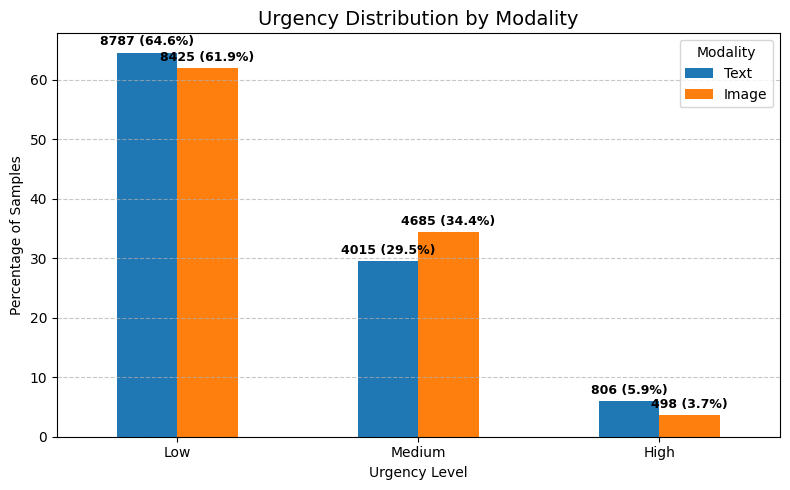

In [12]:
high_urgency = {
    "injured_or_dead_people",
    "missing_or_found_people",
    "affected_individuals"
}

medium_urgency = {
    "infrastructure_and_utility_damage",
    "vehicle_damage",
    "rescue_volunteering_or_donation_effort"
}

low_urgency = {
    "other_relevant_information",
    "not_humanitarian"
}

def map_urgency(label):
    if label in high_urgency:
        return "High"
    elif label in medium_urgency:
        return "Medium"
    else:
        return "Low"


df["urgency_text_eda"] = df["label_text"].astype(str).apply(map_urgency)
df["urgency_image_eda"] = df["label_image"].astype(str).apply(map_urgency)


# Percentages
urg_text_pct = (
    df["urgency_text_eda"]
    .value_counts(normalize=True)
    .reindex(["Low", "Medium", "High"])
    * 100
)
urg_image_pct = (
    df["urgency_image_eda"]
    .value_counts(normalize=True)
    .reindex(["Low", "Medium", "High"])
    * 100
)

# Counts
urg_text_cnt = (
    df["urgency_text_eda"]
    .value_counts()
    .reindex(["Low", "Medium", "High"])
)
urg_image_cnt = (
    df["urgency_image_eda"]
    .value_counts()
    .reindex(["Low", "Medium", "High"])
)

# Combine into DataFrame (percentages for plotting)
urg_df = pd.DataFrame({
    "Text": urg_text_pct,
    "Image": urg_image_pct
})

ax = urg_df.plot(
    kind="bar",
    figsize=(8, 5)
)

# Annotate with counts + percentages directly above each bar
for bars, modality in zip(ax.containers, urg_df.columns):
    counts = urg_text_cnt if modality == "Text" else urg_image_cnt
    for bar, pct, cnt in zip(bars, urg_df[modality], counts):
        height = bar.get_height()
        ax.annotate(
            f"{cnt} ({pct:.1f}%)",
            xy=(bar.get_x() + bar.get_width() / 2, height),
            xytext=(0, 3),  # offset in points
            textcoords="offset points",
            ha="center", va="bottom",
            fontsize=9, fontweight="bold"
        )

ax.set_title("Urgency Distribution by Modality", fontsize=14)
ax.set_xlabel("Urgency Level")
ax.set_ylabel("Percentage of Samples")
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)
ax.grid(axis="y", linestyle="--", alpha=0.7)
ax.legend(title="Modality")

plt.tight_layout()
plt.show()

## Exploratory Data Analysis (EDA) & Findings

A comprehensive analysis was conducted on the CrisisMMD v2.0 dataset (Training Split: 13,608 samples) to inform the architectural design and preprocessing strategy.

### 1. Data Integrity and Quality
* **Completeness:** The dataset is technically clean. There are zero missing values in the text/image path columns and zero unreadable/corrupt image files.
* **Multi-Modal Availability:** Every text entry is paired with at least one image. Approximately **10% (1,145)** of tweets contain multiple images.
    * *Decision:* To maintain architectural simplicity for the baseline, we will utilize the **first image** for each tweet, noting that this captures the primary visual context for 90% of the data.

### 2. Input Dimensions & Preprocessing Requirements
* **Text Modality:**
    * Tweets are concise, with a median length of **122 characters** and **46 tokens** (using DistilBERT tokenizer).
    * The **95th percentile** token length is **57**.
    * *Decision:* A maximum sequence length of **128 tokens** is more than sufficient, allowing us to capture the full semantic context without truncation for >99% of samples.
* **Visual Modality:**
    * Image resolutions vary significantly (Median: 900x650), with a landscape-dominant aspect ratio (1.5).
    * *Decision:* All images must be resized and center-cropped to **224x224** to match the ResNet-50 input requirements. Standard ImageNet normalization will be applied to handle the varying brightness and exposure levels observed in the statistics.

### 3. Class Imbalance (The "Urgency" Distribution)
The dataset exhibits significant class imbalance when mapped to our proposed Urgency levels:
* **Low Urgency / Irrelevant:** Dominant classes like `not_humanitarian`represent ~64%.
* **Medium Urgency:** Moderate representation ~32% eg:`infrastructure_damage`: .
* **High Urgency:** Critical categories like `missing_people` or `injured_people` represent <5% of the data.
* *Decision:* This severe imbalance confirms the absolute necessity of using **Weighted Cross-Entropy Loss** during training to prevent the model from ignoring the rare but critical "High Urgency" cases.

### 4. The Case for Multimodal Fusion
A crucial finding is the low agreement between text-only and image-only labels:
* **Raw Agreement:** ~45%
* **Cohen’s Kappa:** **0.283** (Low Agreement)
The confusion matrix reveals frequent discrepancies; for instance, tweets labeled `other_relevant` by text are often labeled `infrastructure_damage` by the image content. This confirms that **one modality alone is insufficient** for accurate classification. A Late-Fusion architecture is statistically justified to resolve these conflicts.